# Analysis of the gills
- Oleksiy and Flu scanned them
- Dea delineated them
- David does the analysis

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
seaborn.set_style('dark')
try:
    from matplotlib_scalebar.scalebar import ScaleBar
except:
    print('No scalebars')
import os
import platform
import pandas
import glob
import scipy.misc
import scipy.stats
import numpy
import skimage.filters
import skimage.morphology
import gc

In [2]:
# My figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit
plt.rcParams["savefig.transparent"] = False

In [3]:
# Setup scale bar
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [4]:
def get_git_hash():
    """
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    """
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git', '--git-dir', os.path.join(os.getcwd(), '.git'),
                        'rev-parse', '--short', '--verify', 'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [5]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [6]:
# Work on the fast SSD from here on!
FastSSD = True
if 'debian' in platform.dist():
    if FastSSD:
        StartDir = '/media/habi/Fast_SSD/'
    else:
        StartDir = '/media/habi/Blue Seagate/'
else:
    if FastSSD:
        StartDir = 'F:/'
    else:
        StartDir = 'G:/'
RootFolder = os.path.join(StartDir, 'Zebra-Fish_Matthias')

In [7]:
print('We are loading all the data from %s' % RootFolder)

We are loading all the data from /media/habi/Fast_SSD/Zebra-Fish_Matthias


In [8]:
# Make directory for output
OutPutDir = os.path.join(os.getcwd(), 'Output', get_git_hash())
print('We are saving the output images to %s' % OutPutDir)
os.makedirs(OutPutDir, exist_ok=True)

We are saving the output images to /home/habi/P/Documents/Zebrafish-Gills/Output/45a6e9a


In [9]:
# Display all plots identically
lines = 5
# And then do something like
# plt.subplot(lines, numpy.ceil(len(ROIFolder) / float(lines)), c + 1)

Let's get going, now that we set up everything...

In [10]:
# Get a list of all the samples we scanned
SampleNames = sorted(next(os.walk(RootFolder))[1])

In [11]:
# Remove Folder we don't want
if not FastSSD:
    SampleNames.remove('Original SEM Bilder')
    SampleNames.remove('tresholding_estimation')

In [12]:
# Save all the information into a pandas dataframe
Data = pandas.DataFrame({'Sample': SampleNames})
Data['Folder'] = [os.path.join(RootFolder, s) for s in SampleNames]
Data['LogFile'] = [sorted(glob.glob(os.path.join(f, 'proj', '*.log')))[0] for f in Data.Folder]
Data['RecFolder'] = [os.path.join(RootFolder, f, 'rec') for f in Data.Folder]
Data['VOIFolder'] = [os.path.join(RootFolder, f, 'VOI') for f in Data.Folder]
Data['OverviewName'] = [glob.glob(os.path.join(r, '*spr.bmp'))[0] for r in Data.RecFolder]
# Data['ReconstructionNames'] = [sorted(glob.glob(os.path.join(r, '*.png'))) for r in Data.RecFolder]
Data['VOINames'] = [sorted(glob.glob(os.path.join(r, '*.png'))) for r in Data.VOIFolder]

In [13]:
# Make an 'experiment' column, which we use for the box plots below
def whichexperiment(i):
    '''Categorize  into 'Swimmer' or 'Control' '''
    if 'immer' in i:
        return 'Swimmer'
    if 'ontrol' in i:
        return 'Control'

In [14]:
Data['Experiment'] = [whichexperiment(name) for name in Data.Folder]

In [15]:
# Color plot based on label (mrt, ctrl or bb)
def color_based_on_experiment(i):
    '''Colorize into 'Swimmer' or 'Control' '''
    if 'ontrol' in i:
        return seaborn.color_palette()[0]
    if 'immer' in i:
        return seaborn.color_palette()[1]

In [16]:
Data['Color'] = [color_based_on_experiment(name) for name in Data.Folder]

In [183]:
# Read the xls-sheet I got from Matthias with the fish data
# I've copied the relevant data to a new sheet
datafile = glob.glob('G*.xlsx')[0]
xl = pandas.ExcelFile(datafile)
length = xl.parse("size_after")
Data['Length'] = pandas.concat([length.Control, length.Swimmers], ignore_index=True)

In [17]:
# Get Pixel sizes of the scans
Data['PixelSize'] = [get_pixelsize(logfile) for logfile in Data.LogFile]

In [18]:
Data.head()

,Sample,Folder,LogFile,RecFolder,VOIFolder,OverviewName,VOINames,Experiment,Color,PixelSize
0,Control01,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,[/media/habi/Fast_SSD/Zebra-Fish_Matthias/Cont...,Control,"(0.12156862745098039, 0.4666666666666667, 0.70...",1.660000
1,Control02,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,[/media/habi/Fast_SSD/Zebra-Fish_Matthias/Cont...,Control,"(0.12156862745098039, 0.4666666666666667, 0.70...",1.650013
2,Control03,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,[/media/habi/Fast_SSD/Zebra-Fish_Matthias/Cont...,Control,"(0.12156862745098039, 0.4666666666666667, 0.70...",1.650013
3,Control04,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,[/media/habi/Fast_SSD/Zebra-Fish_Matthias/Cont...,Control,"(0.12156862745098039, 0.4666666666666667, 0.70...",1.660000
4,Control05,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,[/media/habi/Fast_SSD/Zebra-Fish_Matthias/Cont...,Control,"(0.12156862745098039, 0.4666666666666667, 0.70...",1.660000


In [19]:
# Load Overviews (not into the dataframe, to keep things speedy)
Overviews = [scipy.misc.imread(o, flatten=True) for o in Data.OverviewName]

/home/habi/P/Dev/matplotlib-scalebar/matplotlib_scalebar/scalebar.py:449: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if is_string_like(loc):
/home/habi/P/Dev/matplotlib-scalebar/matplotlib_scalebar/scalebar.py:290: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if is_string_like(location):


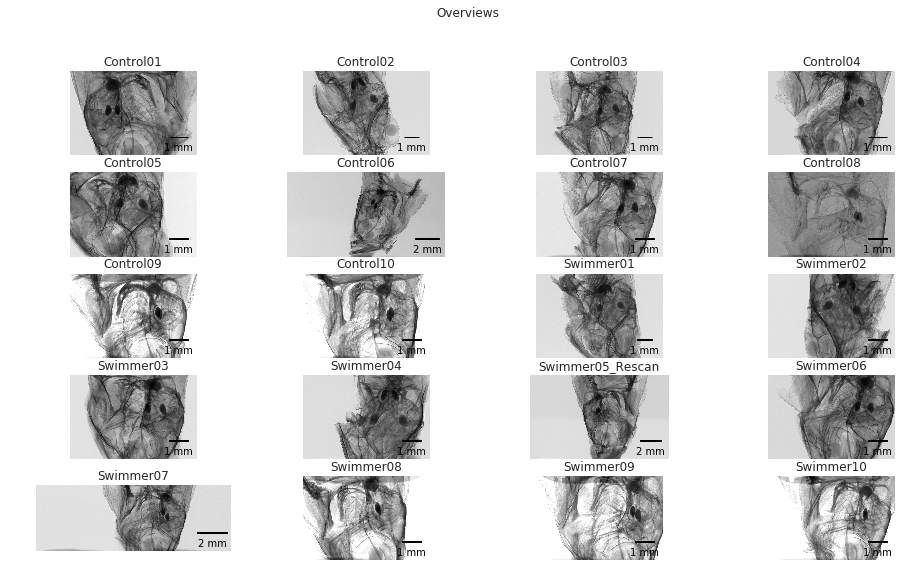

In [20]:
# Display overviews (shadow projections)
for c, o in enumerate(Overviews):
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.imshow(o)
    try:
        plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um', color = 'black'))
    except:
        pass
    plt.axis('off')
    plt.title('%s' % Data.Sample[c])
plt.suptitle('Overviews')
plt.savefig(os.path.join(OutPutDir, 'Shadowprojections.png'), bbox_inches='tight')
plt.show()

In [305]:
Data.VOIFolder[0]

'/media/habi/Fast_SSD/Zebra-Fish_Matthias/Control01/VOI'

In [21]:
# Convert *all* VOI slices into several single NumPy arrays and save them to disk
# But only do this if we didn't do it already :)
# Partially based on http://stackoverflow.com/a/39195332/323100
# Since we reload/memorymap the stack below again, we overwrite the variable with NAN and clear the memory
Data['OutputNameVOI'] = [os.path.join(f, sample + '_VOI.npy') for f, sample in zip(Data.Folder, Data.Sample)]
# Don't save into the dataframe, or else we won't be able to make it :)
VOIImages = [numpy.nan for file in Data.OutputNameVOI]
for c, voi in enumerate(Data.OutputNameVOI):   
    # Only do this if we didn't do it already...
    if os.path.exists(voi):
        print('%2s/%s: %16s: Already saved to %s' % (c+1, len(Data.Sample), Data.Sample[c], voi[len(RootFolder):]))
    else:
        print('%2s/%s: %16s: Reading %4s VOI images' % (c+1,len(Data.Sample), Data.Sample[c], len(Data.VOINames[c])))
        # Actually load the images now
        VOIImages[c] = numpy.array([numpy.array(scipy.misc.imread(i, flatten = True)) for i in Data.VOINames[c]])
        # Save the images to NumPy binary files, disallowing pickle for portability
        print('%23s: Saving to %s' % (Data.Sample[c], voi))
        numpy.save(voi, VOIImages[c], allow_pickle=False)
        # Clear memory 
        VOIImages[c] = numpy.nan
        gc.collect()

 1/20:        Control01: Already saved to /Control01/Control01_VOI.npy
 2/20:        Control02: Already saved to /Control02/Control02_VOI.npy
 3/20:        Control03: Already saved to /Control03/Control03_VOI.npy
 4/20:        Control04: Already saved to /Control04/Control04_VOI.npy
 5/20:        Control05: Already saved to /Control05/Control05_VOI.npy
 6/20:        Control06: Already saved to /Control06/Control06_VOI.npy
 7/20:        Control07: Already saved to /Control07/Control07_VOI.npy
 8/20:        Control08: Already saved to /Control08/Control08_VOI.npy
 9/20:        Control09: Already saved to /Control09/Control09_VOI.npy
10/20:        Control10: Already saved to /Control10/Control10_VOI.npy
11/20:        Swimmer01: Already saved to /Swimmer01/Swimmer01_VOI.npy
12/20:        Swimmer02: Already saved to /Swimmer02/Swimmer02_VOI.npy
13/20:        Swimmer03: Already saved to /Swimmer03/Swimmer03_VOI.npy
14/20:        Swimmer04: Already saved to /Swimmer04/Swimmer04_VOI.npy
15/20:

In [22]:
# Free the memory of the images we loaded.
# We 'memory-map' them again below
%xdel VOIImages

In [23]:
# Load (or memory-map) all the files.
# This is loading the images like a virtual stack in ImageJ
VOIImages = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOI]

In [24]:
# Load a random file to get the image size
Data['VOIShape'] = [numpy.shape(n[numpy.random.randint(len(n))]) for n in VOIImages]

In [25]:
# Get ourselves the middle slice to show
Data['MiddleSliceName'] = [n[len(n)//2] for n in Data.VOINames]
Data['MiddleSlice'] = [i[len(i)//2] for i in VOIImages]

/home/habi/P/Dev/matplotlib-scalebar/matplotlib_scalebar/scalebar.py:449: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if is_string_like(loc):
/home/habi/P/Dev/matplotlib-scalebar/matplotlib_scalebar/scalebar.py:290: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if is_string_like(location):


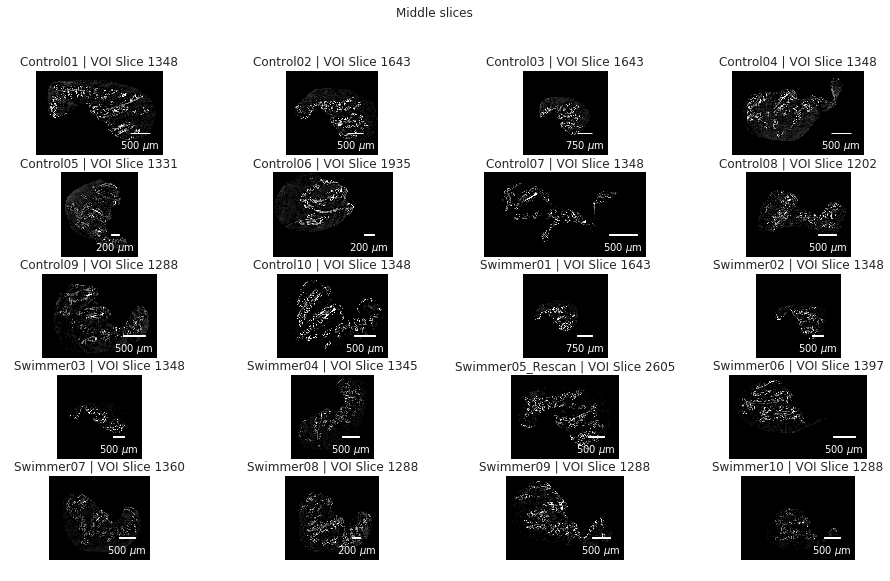

In [26]:
# Display the middle slice of the VOI
for c, m in enumerate(Data.MiddleSlice):
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.imshow(m, vmax=0.618 * numpy.max(m))
    plt.title('%s | VOI Slice %s' % (Data.Sample[c], os.path.basename(Data.MiddleSliceName[c])[-8:-4]))
    try:
        plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um'))
    except:
        pass
    plt.axis('off')
plt.suptitle('Middle slices')
plt.savefig(os.path.join(OutPutDir, 'MiddleSlices.png'), bbox_inches='tight')
plt.show()

In [27]:
Data['NumberOfVOISlices'] = [len(v) for v in Data.VOINames]

In [29]:
print('We have VOIs with %s to %s slices' % (Data.NumberOfVOISlices.min(), Data.NumberOfVOISlices.max()))
# plt.scatter(x=Data.Sample, y=Data.NumberOfVOISlices, c=Data.Color)
# plt.title('Number of VOI slices')
# plt.show()

We have VOIs with 2239 to 3389 slices


In [227]:
# Use a manageable amount of equally spaced slices for thresholding and MIP-ing
# NumberOfImagesToShow = 6
# NumberOfImagesToShow = 16
NumberOfImagesToShow = 111
# NumberOfImagesToShow = 222
# NumberOfImagesToShow = 350

In [228]:
# Generate the subset information
Data['PrintEverySlice'] = [int(round(len(r)/NumberOfImagesToShow)) for r in Data.VOINames]
Data['SubsetNames']= [rn[::sw] for rn, sw in zip(Data.VOINames, Data.PrintEverySlice)]
for c, i in enumerate(Data.Sample):
    print('For %s we are working with a subset of %s (%0.1f %% of totally %s) equally '
          'spaced slices' % (i, len(Data.SubsetNames[c]), len(Data.SubsetNames[c]) / len(Data.VOINames[c]) * 100, 
                             len(Data.VOINames[c])))

For Control01 we are working with a subset of 112 (4.6 % of totally 2452) equally spaced slices
For Control02 we are working with a subset of 110 (3.6 % of totally 3062) equally spaced slices
For Control03 we are working with a subset of 110 (3.6 % of totally 3062) equally spaced slices
For Control04 we are working with a subset of 112 (4.6 % of totally 2452) equally spaced slices
For Control05 we are working with a subset of 111 (4.2 % of totally 2642) equally spaced slices
For Control06 we are working with a subset of 110 (3.2 % of totally 3389) equally spaced slices
For Control07 we are working with a subset of 112 (4.6 % of totally 2452) equally spaced slices
For Control08 we are working with a subset of 110 (4.6 % of totally 2400) equally spaced slices
For Control09 we are working with a subset of 112 (4.4 % of totally 2572) equally spaced slices
For Control10 we are working with a subset of 112 (4.6 % of totally 2452) equally spaced slices
For Swimmer01 we are working with a subs

In [229]:
# Put len of 'UseThis' into dataframe
Data['NumberOfAnalyzedVOISlices'] = [len((a)) for a in Data.SubsetNames]

In [230]:
# Calculate the thresholds of each slice
Data['OutputNameThreshold'] = [os.path.join(f,
                                            sample +  '_thresholds_from_%04d_of_%04d_slices.npy' % (len(n[::p]),
                                                                                                    len(n)))
                               for f, sample, n, p in zip(Data.Folder,
                                                          Data.Sample,
                                                          Data.VOINames,
                                                          Data.PrintEverySlice)]
Data['Threshold'] = [[numpy.nan] for s in Data.Sample]
for c, thresholdname in enumerate(Data.OutputNameThreshold):
    if os.path.exists(thresholdname):
        print('%2s/%s: %15s: Grab values from %s' % (c+1,
                                                     len(Data),
                                                     Data.Sample[c],
                                                     thresholdname[len(RootFolder):]))
        Data['Threshold'][c] = numpy.load(thresholdname)
    else:
        print('%2s/%s: %16s: Calculating thresholds for %s of %4s files' % (c+1,
                                                                            len(Data), Data.Sample[c],
                                                                            len(Data.VOINames[c][::Data.PrintEverySlice[c]]),
                                                                            len(Data.VOINames[c])))
        Data['Threshold'][c] = [numpy.nan] * len(Data.VOINames[c][::Data.PrintEverySlice[c]])
        for d, image in enumerate(VOIImages[c][::Data.PrintEverySlice[c]]):
            try:
                # Calculate and save threshold
                Data['Threshold'][c][d] = skimage.filters.threshold_otsu(image)
            except (ValueError):
                # Save NAN if we can't calculate a threshold
                Data['Threshold'][c][d] = numpy.nan
        print('%23s: Saving thresholds to %s' % (Data.Sample[c], thresholdname[len(RootFolder):]))                
        numpy.save(thresholdname, Data.Threshold[c], allow_pickle=False)

 1/20:       Control01: Grab values from /Control01/Control01_thresholds_from_0112_of_2452_slices.npy


/home/habi/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


 2/20:       Control02: Grab values from /Control02/Control02_thresholds_from_0110_of_3062_slices.npy
 3/20:       Control03: Grab values from /Control03/Control03_thresholds_from_0110_of_3062_slices.npy
 4/20:       Control04: Grab values from /Control04/Control04_thresholds_from_0112_of_2452_slices.npy
 5/20:       Control05: Grab values from /Control05/Control05_thresholds_from_0111_of_2642_slices.npy
 6/20:       Control06: Grab values from /Control06/Control06_thresholds_from_0110_of_3389_slices.npy
 7/20:       Control07: Grab values from /Control07/Control07_thresholds_from_0112_of_2452_slices.npy
 8/20:       Control08: Grab values from /Control08/Control08_thresholds_from_0110_of_2400_slices.npy
 9/20:       Control09: Grab values from /Control09/Control09_thresholds_from_0112_of_2572_slices.npy
10/20:       Control10: Grab values from /Control10/Control10_thresholds_from_0112_of_2452_slices.npy
11/20:       Swimmer01: Grab values from /Swimmer01/Swimmer01_thresholds_from_0110

In [231]:
# Let's calculate the mean and median threshold for each sample
Data['ThresholdAverage'] = [numpy.nanmean(t) for t in Data.Threshold]
Data['ThresholdMedian'] = [numpy.nanmedian(t) for t in Data.Threshold]

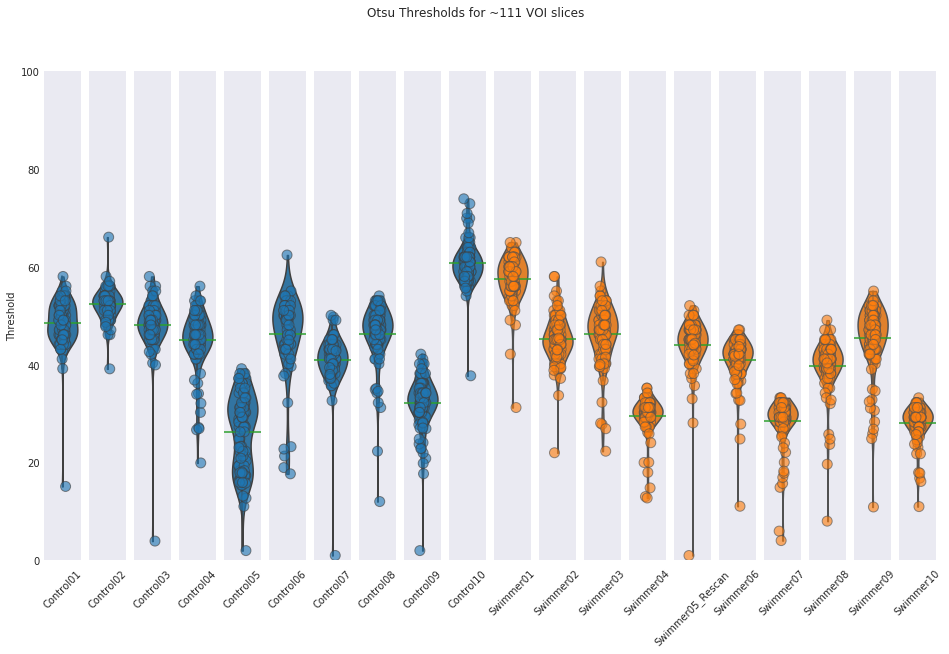

In [232]:
# Boxplots of the Thresholds
for c, i in enumerate(Data.Threshold):
    plt.subplot(1,len(Data), c+1)
    seaborn.violinplot(i, orient='v', color=Data.Color[c], cut=0)    
    seaborn.stripplot(i, orient='v', color=Data.Color[c], jitter=True, linewidth=1, s=10, alpha=0.618)
    plt.axhline(Data.ThresholdAverage[c], label='Average', color=seaborn.color_palette()[2])
    plt.ylim([0,100])
    if c:
        plt.gca().axes.yaxis.set_ticklabels([])
    else:
        plt.ylabel('Threshold')
    plt.xlabel(Data.Sample[c], rotation=45)
plt.suptitle('Otsu Thresholds for ~%s VOI slices' % NumberOfImagesToShow )
plt.savefig(os.path.join(OutPutDir, 'Thresholds_from%04dslices.png' % NumberOfImagesToShow))
plt.show()

In [233]:
# Read a subset of images
Data['OutputNameVOISubset'] = [os.path.join(f,
                                            sample +  '_VOI_subset_from_%04d_of_%04d_slices.npy' % (len(n[::p]),
                                                                                                    len(n)))
                               for f, sample, n, p in zip(Data.Folder,
                                                          Data.Sample,
                                                          Data.VOINames,
                                                          Data.PrintEverySlice)]
# Don't save into the dataframe, or else we won't be able to make it :)
VOISubset = [numpy.nan for file in Data.OutputNameVOISubset]
for c, subset in enumerate(Data.OutputNameVOISubset):
    # Only do this if we didn't do it already...
    if os.path.exists(subset):
        print('%2s/%s: %16s: Already saved to %s' % (c+1,
                                                     len(Data.Sample),
                                                     Data.Sample[c],
                                                     subset[len(RootFolder):]))
    else:
        print('%2s/%s: %16s: Subsetting %s of %s VOI images' % (c+1,
                                                                len(Data.Sample),
                                                                Data.Sample[c],
                                                                len(Data.SubsetNames[c]),
                                                                len(Data.VOINames[c])))
        
        
        
        
        VOISubset[c] = [numpy.nan] * len(Data.VOINames[c][::Data.PrintEverySlice[c]])
        for d, image in enumerate(VOIImages[c][::Data.PrintEverySlice[c]]):
            VOISubset[c][d] = image
        print('%23s: Saving subset to %s' % (Data.Sample[c], subset[len(RootFolder):]))                
        numpy.save(subset, VOISubset[c], allow_pickle=False)
        VOISubset[c] = numpy.nan
        gc.collect()

 1/20:        Control01: Already saved to /Control01/Control01_VOI_subset_from_0112_of_2452_slices.npy
 2/20:        Control02: Already saved to /Control02/Control02_VOI_subset_from_0110_of_3062_slices.npy
 3/20:        Control03: Already saved to /Control03/Control03_VOI_subset_from_0110_of_3062_slices.npy
 4/20:        Control04: Already saved to /Control04/Control04_VOI_subset_from_0112_of_2452_slices.npy
 5/20:        Control05: Already saved to /Control05/Control05_VOI_subset_from_0111_of_2642_slices.npy
 6/20:        Control06: Already saved to /Control06/Control06_VOI_subset_from_0110_of_3389_slices.npy
 7/20:        Control07: Already saved to /Control07/Control07_VOI_subset_from_0112_of_2452_slices.npy
 8/20:        Control08: Already saved to /Control08/Control08_VOI_subset_from_0110_of_2400_slices.npy
 9/20:        Control09: Already saved to /Control09/Control09_VOI_subset_from_0112_of_2572_slices.npy
10/20:        Control10: Already saved to /Control10/Control10_VOI_subset

In [234]:
# Clear the memory
%xdel VOISubset

In [235]:
# Load (or memory-map) all the files.
# This is loading the images like a virtual stack in ImageJ
VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOISubset]

In [236]:
# # Display sampler of slices
# # But only if we have less than 11 HowManySlices
# ShowHistograms = False
# if HowManySlices < 11:
#     for c, m in enumerate(SampleNames):
#         for d, n in enumerate(SubsetNames[c]):
#             if ShowHistograms:
#                 plt.subplot(2, len(SubsetNames[c]), d + 1)
#             else:
#                 plt.subplot(1, len(SubsetNames[c]), d + 1)
#             # Show the selected image
#             plt.imshow(numpy.ma.masked_less(VOIs[c][d],25).filled(0))
#             # Title depending on which image we show
#             if d:
#                 plt.title('VOI %s' % os.path.splitext(os.path.basename(SubsetNames[c][d]))[0][-4:])
#             else:
#                 plt.title('Sample %s\nVOI %s' % (SampleNames[c], os.path.splitext(os.path.basename(SubsetNames[c][d]))[0][-4:]))
#                 # Scalebar on the first image
#                 plt.gca().add_artist(ScaleBar(PixelSize[c], 'um', color='white'))                
#             if ShowHistograms:
#                 plt.subplot(2, len(SubsetNames[c]), d + 1 + len(SubsetNames[c]))
#                 plt.hist(VOIs[c][d][VOIs[c][d]>1].ravel(), log=True)
#                 plt.xlim([0, 255])
#             plt.tight_layout
#             plt.axis('off')
#         plt.savefig(os.path.join(OutPutDir, 'Sampler_%simgs_%s.png' % (len(SubsetNames[c]), SampleNames[c])), bbox_inches='tight')
#         plt.show()
# else:
#     print('Displaying a sampler with ~%s slices does not make sense...' % HowManySlices)

In [237]:
# Read or genereate the MIP
Data['OutputNameMIP'] = [os.path.join(f,
                                      sample +  '_MIP_from_%04d_of_%04d_slices.npy' % (len(n[::p]),
                                                                                       len(n)))
                         for f, sample, n, p in zip(Data.Folder,
                                                    Data.Sample,
                                                    Data.VOINames,
                                                    Data.PrintEverySlice)]
MIPs = [None] * len(Data)
for c, fn in enumerate(Data.OutputNameMIP):
    if os.path.exists(fn):
        print('%s/%s: Loading %s into memory' % (c+1, len(Data), fn[len(RootFolder):]))
        MIPs[c] = numpy.load(fn, mmap_mode='r')
    else:
        print('%s/%s: Generating MIP from %s images' % (c+1, len(Data), len(Data.SubsetNames[c])))
        MIPs[c]=numpy.max(VOISubset[c], axis=0)
        numpy.save(fn, MIPs[c], allow_pickle=False)
    # Save MIPs to PNG image
    scipy.misc.imsave(os.path.splitext(fn)[0] + '.png', MIPs[c])        

1/20: Loading /Control01/Control01_MIP_from_0112_of_2452_slices.npy into memory
2/20: Loading /Control02/Control02_MIP_from_0110_of_3062_slices.npy into memory
3/20: Loading /Control03/Control03_MIP_from_0110_of_3062_slices.npy into memory
4/20: Loading /Control04/Control04_MIP_from_0112_of_2452_slices.npy into memory
5/20: Loading /Control05/Control05_MIP_from_0111_of_2642_slices.npy into memory
6/20: Loading /Control06/Control06_MIP_from_0110_of_3389_slices.npy into memory
7/20: Loading /Control07/Control07_MIP_from_0112_of_2452_slices.npy into memory
8/20: Loading /Control08/Control08_MIP_from_0110_of_2400_slices.npy into memory
9/20: Loading /Control09/Control09_MIP_from_0112_of_2572_slices.npy into memory
10/20: Loading /Control10/Control10_MIP_from_0112_of_2452_slices.npy into memory
11/20: Loading /Swimmer01/Swimmer01_MIP_from_0110_of_3062_slices.npy into memory
12/20: Loading /Swimmer02/Swimmer02_MIP_from_0112_of_2452_slices.npy into memory
13/20: Loading /Swimmer03/Swimmer03_M

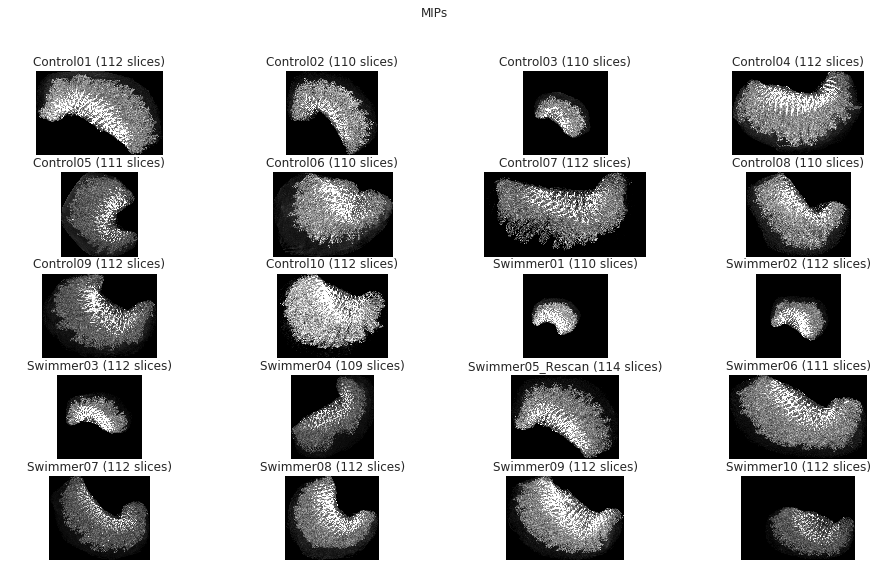

In [238]:
# Display 'through-the-sample' MIPs
for c, m in enumerate(MIPs):
    plt.subplot(lines, numpy.ceil(len(SampleNames) / float(lines)), c + 1)
    plt.imshow(m)
    try:
        plt.gca().add_artist(ScaleBar(PixelSize[c], 'um'))
    except:
        pass
    plt.title('%s (%s slices)' % (SampleNames[c], len(Data.SubsetNames[c])))
    plt.axis('off')
plt.suptitle('MIPs')
plt.savefig(os.path.join(OutPutDir, 'MIPs_from%04dslices.png' % NumberOfImagesToShow), bbox_inches='tight')
plt.show()

In [239]:
Otsu_MIP = [skimage.filters.threshold_otsu(image) for image in MIPs]

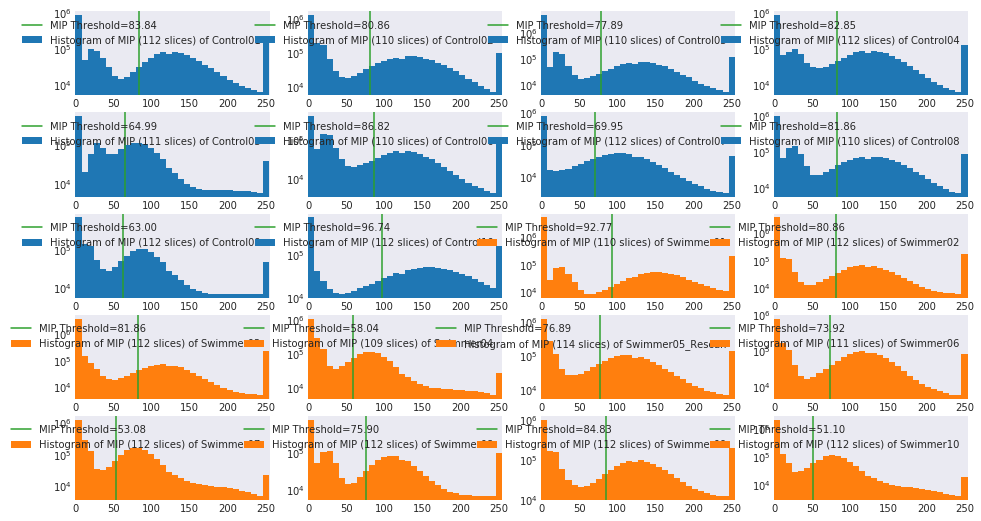

In [240]:
# Display MIP Histograms
for c, m in enumerate(MIPs):
    plt.subplot(lines, numpy.ceil(len(SampleNames) / float(lines)), c + 1)
    plt.hist(m.ravel(), log=True, bins=32, color=Data.Color[c],
             label='Histogram of MIP (%s slices) of %s' % (len(Data.SubsetNames[c]), Data.Sample[c]))
    plt.axvline(Otsu_MIP[c], c=seaborn.color_palette()[2], label='MIP Threshold=%0.2f' % Otsu_MIP[c])
    plt.xlim([0,255])
    plt.legend()
plt.savefig(os.path.join(OutPutDir, 'MIP_Histograms_from%04dslices.png' % NumberOfImagesToShow), bbox_inches='tight')
plt.show()

In [241]:
CalculateAllThresholds = False

In [242]:
if CalculateAllThresholds:
    # This will take a long time, since we calculate the threshold for *every* image!
    # If the image is only black (numpy.mean(image)==0), save 'None' as Threshold...
    Otsu = [[skimage.filters.threshold_otsu(image) if numpy.mean(image) else numpy.nan for image in sample] for sample in VOISubset]

In [243]:
if CalculateAllThresholds:
    # grab the thresholds in the 60-80% range of the respective values
    split = 5
    Selected = [sorted(t)[(split-2)*len(t)//split:(split-1)*len(t)//split] if t else numpy.nan for t in Otsu]
    # mask the values of the threshold that are *not* in this range
    Otsu_selected = [numpy.ma.masked_outside(o, numpy.min(sel), numpy.max(sel)) for o, sel in zip(Otsu, Selected)]
    # use the mean of this 60-80% value to threshold the datasets
    GlobalThreshold = [numpy.nanmean(os) for os in Otsu_selected]

In [244]:
# FORCE THRESHOLD
# GlobalThreshold = [20 for t in GlobalThreshold]

In [245]:
# Grab the maximal amount of images, for scaling the plots
MaxImages = 0
for i in Data.SubsetNames:
    MaxImages = max(MaxImages, len(i))

In [246]:
if CalculateAllThresholds:
    for c, s in enumerate(SampleNames):
        plt.plot(Otsu[c], marker='.', label='%s | Global Otsu Mean=%.2f | 60-80%% Otsu mean=%0.2f '
                 '| MIP Otsu=%0.2f' % (s,
                                       numpy.nanmean(Otsu[c]),
                                       GlobalThreshold[c],
                                       Otsu_MIP[c]),
                 c=seaborn.color_palette(n_colors=len(SampleNames))[c])
        plt.plot(Otsu_selected[c], '.', ms=20, alpha=0.618, markeredgecolor='k', markeredgewidth=1, 
                 c=seaborn.color_palette(n_colors=len(SampleNames))[c])
        plt.axhline(Otsu_MIP[c], alpha=0.618, c=seaborn.color_palette(n_colors=len(SampleNames))[c])
        plt.legend(loc='best')
    plt.xlim([0, MaxImages - 1])
    plt.title('Otsu thresholds for each slice of each sample')
    plt.savefig(os.path.join(OutPutDir, 'Thresholds.png'), bbox_inches='tight')
    plt.show()

In [247]:
if CalculateAllThresholds:
    GlobalOtsu = [skimage.filters.threshold_otsu(numpy.array(r)) if r.any() else numpy.nan for r in VOISubset]

In [248]:
if CalculateAllThresholds:
    # Compare global Otsu threshold, 60%-80% selected threshold and threshold from MIPs
    for c,s in enumerate(SampleNames):
        print('For %s we have a' % s)
        print('\t- 60-80%% selected threshold of %0.2f' % GlobalThreshold[c])
        print('\t- global Otsu threshold of %0.2f' % GlobalOtsu[c])
        print('\t- Otsu threshold calculated from the MIP of %0.2f' % Otsu_MIP[c])

In [249]:
# Show all (global) histograms
# This takes a while, since we 'ravel' all images from the subsets and calculate their histogram...
if not True:
    for c, s in enumerate(SampleNames):
        plt.subplot(lines, numpy.ceil(len(SampleNames) / float(lines)), c + 1)
        plt.hist(numpy.array(VOISubset[c]).ravel(), bins=32, log=True, color=Data.Color[c], 
                 label='%s | %s VOI slices' % (s, len(VOISubset[c])))
        if CalculateAllThresholds:
            plt.axvline(GlobalThreshold[c],
                        label='Selected Threshold: %0.2f' % GlobalThreshold[c],
                        c=seaborn.color_palette()[2])
            plt.axvline(GlobalOtsu[c], label='Mean Otsu Threshold: %0.2f' % GlobalOtsu[c],
                        c=seaborn.color_palette()[3])
        plt.axvline(Otsu_MIP[c], label='MIP Otsu Threshold: %0.2f' % Otsu_MIP[c],
                    c=seaborn.color_palette()[4])
        plt.legend()
        plt.xlim([0, 255])
    plt.savefig(os.path.join(OutPutDir, 'Histograms_Thresholds_from%04dslices.png' % NumberOfImagesToShow), bbox_inches='tight')
    plt.show()

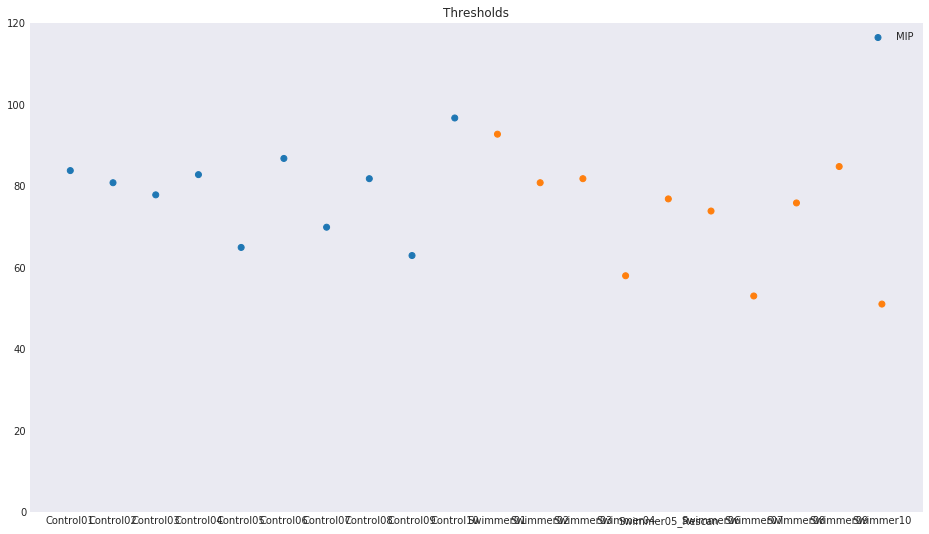

In [250]:
y_max = 120
if CalculateAllThresholds:
    plt.subplot(131)
plt.scatter(x=Data.Sample, y=Otsu_MIP, label='MIP', c=Data.Color)
plt.legend()
plt.ylim([0,y_max])
if CalculateAllThresholds:
    plt.subplot(132)
    plt.scatter(x=Data.Sample, y=GlobalOtsu, label='GobalOtsu', c=Data.Color)
    plt.legend()
    plt.ylim([0,y_max])
    plt.subplot(133)
    plt.scatter(x=Data.Sample, y=GlobalThreshold, label='GlobalThreshold', c=Data.Color)
    plt.legend()
    plt.ylim([0,y_max])
plt.title('Thresholds')
plt.show()

In [308]:
# # Show middle images with some data
# plt.rcParams['figure.figsize'] = (16, 5)
# for c,s in enumerate(SampleNames):
#    maximum = skimage.filters.rank.maximum(Data.MiddleSlice[c].astype('uint8'), skimage.morphology.disk(25))
#    plt.subplot(141)
#    plt.imshow(Data.MiddleSlice[c])
#    try:
#        plt.gca().add_artist(ScaleBar(PixelSize[c], 'um'))
#    except:
#        pass
#    plt.title('Middle slice of %s' % s)
#    plt.subplot(142)
#    plt.imshow(Data.MiddleSlice[c], vmax=0.618*numpy.max(Data.MiddleSlice[c]))
#    plt.imshow(maximum, cmap='viridis', alpha=0.5)
#    try:
#        plt.gca().add_artist(ScaleBar(PixelSize[c], 'um'))    
#    except:
#        pass
#    plt.title('%s with local maxima' % os.path.basename(Data.MiddleSliceName[c]))
#    plt.subplot(143)
#    plt.hist(Data.MiddleSlice[c].ravel(), bins=32, log=True, color=Data.Color[c])
#    if CalculateAllThresholds:
#        plt.axvline(GlobalThreshold[c], c=seaborn.color_palette()[1], label='Global Treshold@%0.2f' % GlobalThreshold[c])
#        plt.axvline(GlobalThreshold[c],
#                    label='Selected Threshold: %0.2f' % GlobalThreshold[c],
#                    c=seaborn.color_palette()[2])
#        plt.axvline(GlobalOtsu[c], label='Global Otsu Threshold: %0.2f' % GlobalOtsu[c],
#                    c=seaborn.color_palette()[3])        
#    plt.axvline(Otsu_MIP[c], c=seaborn.color_palette()[4], label='MIP Otsu Treshold: %0.2f' % Otsu_MIP[c])        
#    plt.legend(loc='best')
#    plt.xlim([0,255])
#    plt.title('Histogram of middle slice')
#    plt.subplot(144)
#    plt.imshow(MIPs[c])
#    plt.title('MIP of %s slices of %s' % (len(Data.SubsetNames[c]),
#                                          Data.Sample[c]))
#    try:
#        plt.gca().add_artist(ScaleBar(PixelSize[c], 'um'))
#    except:
#        pass
#    plt.savefig(os.path.join(OutPutDir, 'Details_%s.png' % Data.Sample[c]), bbox_inches='tight')
#    plt.show()
# plt.rcParams['figure.figsize'] = (16, 9)

In [252]:
def calculate_area_gills(image, threshold=None):
    if not threshold:
        # Calculate the Otsu threshold of the image if needed
        try:
            threshold = skimage.filters.threshold_otsu(image)
        except (ValueError):
            threshold = 0
    thresholded_image = image > threshold
    area_gills = numpy.sum(thresholded_image)
    return(area_gills)

In [253]:
# Calculate the gill area (pythonic way, but without saving it in the middle...)
# Data['AreaGills'] = [[calculate_area_gills(i, threshold=t)
#                       for i, t in zip(subset, thrs)]
#                      for subset, thrs in zip(VOISubset, Data.Threshold)]

In [254]:
# Calculate the gill area (slow way, but with saving it in the middle...)
Data['OutputNameAreaGills'] = [os.path.join(f,
                                           sample +  '_area_gills_from_%04d_of_%04d_slices.npy' % (len(n[::p]),
                                                                                                   len(n)))
                               for f, sample, n, p in zip(Data.Folder,
                                                          Data.Sample,
                                                          Data.VOINames,
                                                          Data.PrintEverySlice)]
# Don't save into the dataframe, or else we won't be able to make it :)
Data['AreaGills'] = [numpy.nan for file in Data.OutputNameAreaGills]
for c, subset in enumerate(VOISubset):
    # Only do this if we didn't do it already...
    if os.path.exists(Data.OutputNameAreaGills[c]):
        print('%2s/%s: %16s: Already saved to %s' % (c+1,
                                                     len(Data.Sample),
                                                     Data.Sample[c],
                                                     Data.OutputNameAreaGills[c][len(RootFolder):]))
    else:
        print('%2s/%s: %16s: Calculating gill area on %s of %s VOI images' % (c+1,
                                                                              len(Data.Sample),
                                                                              Data.Sample[c],
                                                                              len(Data.SubsetNames[c]),
                                                                              len(Data.VOINames[c])))
        Data.AreaGills[c] = [None] * len(subset)
        for d, image in enumerate(subset):
            Data.AreaGills[c][d] = calculate_area_gills(image, threshold=Data.Threshold[c][d])
        print('%23s: Saving area to %s' % (Data.Sample[c], Data.OutputNameAreaGills[c][len(RootFolder):]))                
        numpy.save(Data.OutputNameAreaGills[c], Data.AreaGills[c], allow_pickle=False)

 1/20:        Control01: Calculating gill area on 112 of 2452 VOI images


/home/habi/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/habi/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/habi/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


              Control01: Saving area to /Control01/Control01_area_gills_from_0112_of_2452_slices.npy
 2/20:        Control02: Calculating gill area on 110 of 3062 VOI images
              Control02: Saving area to /Control02/Control02_area_gills_from_0110_of_3062_slices.npy
 3/20:        Control03: Calculating gill area on 110 of 3062 VOI images
              Control03: Saving area to /Control03/Control03_area_gills_from_0110_of_3062_slices.npy
 4/20:        Control04: Calculating gill area on 112 of 2452 VOI images
              Control04: Saving area to /Control04/Control04_area_gills_from_0112_of_2452_slices.npy
 5/20:        Control05: Calculating gill area on 111 of 2642 VOI images
              Control05: Saving area to /Control05/Control05_area_gills_from_0111_of_2642_slices.npy
 6/20:        Control06: Calculating gill area on 110 of 3389 VOI images
              Control06: Saving area to /Control06/Control06_area_gills_from_0110_of_3389_slices.npy
 7/20:        Control07: Calc

In [255]:
def calculate_area_organ(image, threshold=None, verbose=False):
    if not threshold:
        # Calculate the Otsu threshold of the image if needed
        try:
            threshold = skimage.filters.threshold_otsu(image)
        except (ValueError):
            threshold = 0
    thresholded_image = image > threshold
    binary_closing = True
    if binary_closing:
        # Use simple binary closing
        closed  = skimage.morphology.binary_closing(thresholded_image, selem=skimage.morphology.selem.disk(25))
    else:
        # Close small holes (this could be a bit more robust than simple binary closing)
        imagearea = numpy.shape(image)[0] * numpy.shape(image)[1] 
        closed  = skimage.morphology.remove_small_holes(thresholded_image, area_threshold=imagearea*.618)
    if verbose:
        # mask out Deas ROI
        masked = numpy.ma.masked_equal(image,0)
        # Show the images
        plt.subplot(131)
        plt.imshow(masked.filled(0))
        plt.axis('off')
        plt.title('Original')
        plt.subplot(132)
        plt.imshow(thresholded_image)
        plt.axis('off')
        plt.title('Thresholded with %0.2f: %0.2g px' % (threshold, numpy.sum(thresholded_image)))
        plt.subplot(133)
        plt.imshow(closed)
        plt.axis('off')
        plt.title('Closed: %0.2g px' % numpy.sum(closed))
        plt.show()
    area_organ = numpy.sum(closed)
    return(area_organ)

In [256]:
# Calculate the (extrapolated) organ area (pythonic way, but without saving it in the middle...)
# Data['AreaOrgan'] = [[calculate_area_organ(i, threshold=t)
#                       for i, t in zip(subset, thrs)]
#                      for subset, thrs in zip(VOISubset, Data.Threshold)]

In [257]:
# Calculate the (extrapolated) organ area (slow way, but with saving it in the middle...)
Data['OutputNameAreaOrgan'] = [os.path.join(f,
                                            sample +  '_area_organ_from_%04d_of_%04d_slices.npy' % (len(n[::p]),
                                                                                                   len(n)))
                               for f, sample, n, p in zip(Data.Folder,
                                                          Data.Sample,
                                                          Data.VOINames,
                                                          Data.PrintEverySlice)]
# Don't save into the dataframe, or else we won't be able to make it :)
Data['AreaOrgan'] = [numpy.nan for file in Data.OutputNameAreaOrgan]
for c, subset in enumerate(VOISubset):
    # Only do this if we didn't do it already...
    if os.path.exists(Data.OutputNameAreaOrgan[c]):
        print('%2s/%s: %16s: Already saved to %s' % (c+1,
                                                     len(Data.Sample),
                                                     Data.Sample[c],
                                                     Data.OutputNameAreaOrgan[c][len(RootFolder):]))
    else:
        print('%2s/%s: %16s: Calculating organ area on %s of %s VOI images' % (c+1,
                                                                               len(Data.Sample),
                                                                               Data.Sample[c],
                                                                               len(Data.SubsetNames[c]),
                                                                               len(Data.VOINames[c])))
        Data.AreaOrgan[c] = [None] * len(subset)
        for d, image in enumerate(subset):
            Data.AreaOrgan[c][d] = calculate_area_organ(image, threshold=Data.Threshold[c][d])
        print('%23s: Saving area to %s' % (Data.Sample[c], Data.OutputNameAreaOrgan[c][len(RootFolder):]))                
        numpy.save(Data.OutputNameAreaOrgan[c], Data.AreaOrgan[c], allow_pickle=False)

 1/20:        Control01: Calculating organ area on 112 of 2452 VOI images


/home/habi/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/habi/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/habi/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


              Control01: Saving area to /Control01/Control01_area_organ_from_0112_of_2452_slices.npy
 2/20:        Control02: Calculating organ area on 110 of 3062 VOI images
              Control02: Saving area to /Control02/Control02_area_organ_from_0110_of_3062_slices.npy
 3/20:        Control03: Calculating organ area on 110 of 3062 VOI images
              Control03: Saving area to /Control03/Control03_area_organ_from_0110_of_3062_slices.npy
 4/20:        Control04: Calculating organ area on 112 of 2452 VOI images
              Control04: Saving area to /Control04/Control04_area_organ_from_0112_of_2452_slices.npy
 5/20:        Control05: Calculating organ area on 111 of 2642 VOI images
              Control05: Saving area to /Control05/Control05_area_organ_from_0111_of_2642_slices.npy
 6/20:        Control06: Calculating organ area on 110 of 3389 VOI images
              Control06: Saving area to /Control06/Control06_area_organ_from_0110_of_3389_slices.npy
 7/20:        Control07:

In [284]:
Data['AreaGills'] = [numpy.load(file) for file in Data.OutputNameAreaGills]
Data['AreaOrgan'] = [numpy.load(file) for file in Data.OutputNameAreaOrgan]

In [285]:
Data['VolumeGills'] = [numpy.sum(ag) for ag in Data.AreaGills]
Data['VolumeOrgan'] = [numpy.sum(ao) for ao in Data.AreaOrgan]

In [286]:
Data['GillsPerArea'] = [numpy.divide(ag, ao) for (ag,ao) in zip(Data['AreaGills'], Data['AreaOrgan'])]

/home/habi/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


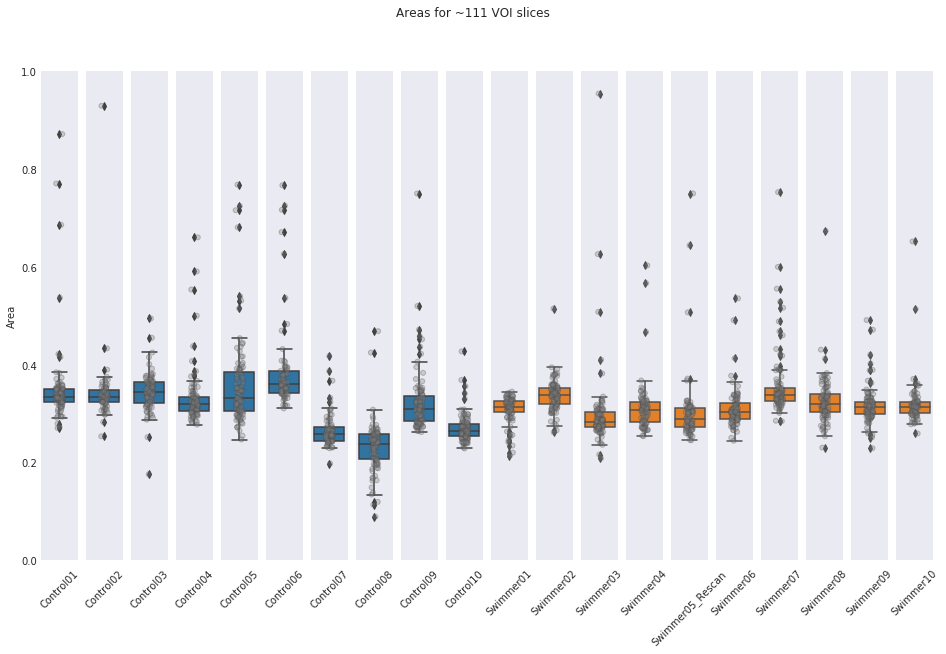

In [289]:
# Boxplots of the Areas
for c, a in enumerate(Data.GillsPerArea):
    plt.subplot(1,len(Data), c+1)
    seaborn.boxplot(a, orient='v', color=Data.Color[c])
#     seaborn.lvplot(a, orient='v', color=Data.Color[c])
    seaborn.stripplot(a, orient='v', jitter=True, linewidth=1, s=5, color='gray', alpha=0.318)
    plt.ylim([0,1])
    if c:
        plt.gca().axes.yaxis.set_ticklabels([])
    else:
        plt.ylabel('Area')
    plt.xlabel(Data.Sample[c], rotation=45)
plt.suptitle('Areas for ~%s VOI slices' % NumberOfImagesToShow )
plt.savefig(os.path.join(OutPutDir, 'Areas_from%04dslices.png' % NumberOfImagesToShow))
plt.show()

In [290]:
Data['MeanArea'] = [float(numpy.nanmean(a)) for a in Data['GillsPerArea']]
Data['MeanVolume'] = [numpy.divide(gv, ov) for gv, ov in zip(Data.VolumeGills, Data.VolumeOrgan)]

In [291]:
Data.MeanArea

0     0.349259
1     0.342515
2     0.344532
3     0.331967
4     0.359200
5     0.388032
6     0.265270
7     0.231712
8     0.322540
9     0.270488
10    0.307966
11    0.337430
12    0.298838
13    0.311443
14    0.301671
15    0.310443
16    0.356092
17    0.325574
18    0.316090
19    0.320086
Name: MeanArea, dtype: float64

In [292]:
Data.MeanVolume

0     0.332625
1     0.331310
2     0.336301
3     0.317692
4     0.340797
5     0.365098
6     0.256207
7     0.227006
8     0.298727
9     0.260325
10    0.311963
11    0.334249
12    0.285464
13    0.296989
14    0.293965
15    0.301293
16    0.335568
17    0.313705
18    0.310298
19    0.308554
Name: MeanVolume, dtype: float64

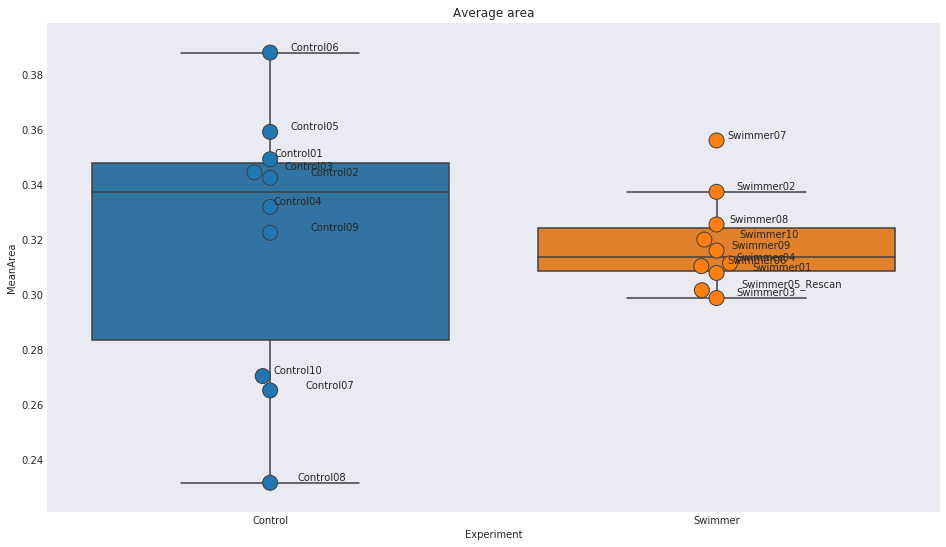

In [293]:
# Boxplot of the mean area for each animal (calculated slice-wise)
seaborn.boxplot(data=Data, x='Experiment', y='MeanArea')
seaborn.swarmplot(data=Data, x='Experiment', y='MeanArea', s=15, linewidth=1)
label=True
if label:
    shift = 0.1
    for c, row in Data.iterrows():
        if Data.Experiment[c] == 'Control':
            plt.gca().annotate(Data.Sample[c], (0 + shift * numpy.random.rand(),
                                                Data.MeanArea[c]),
                               horizontalalignment='left', verticalalignment='bottom')         
        else:
            plt.gca().annotate(Data.Sample[c], (1 + shift * numpy.random.rand(),
                                                Data.MeanArea[c]),
                               horizontalalignment='left', verticalalignment='bottom')
plt.title('Average area')
plt.savefig(os.path.join(OutPutDir, 'Areas_Average_from%04dslices.png' % NumberOfImagesToShow))
plt.show()

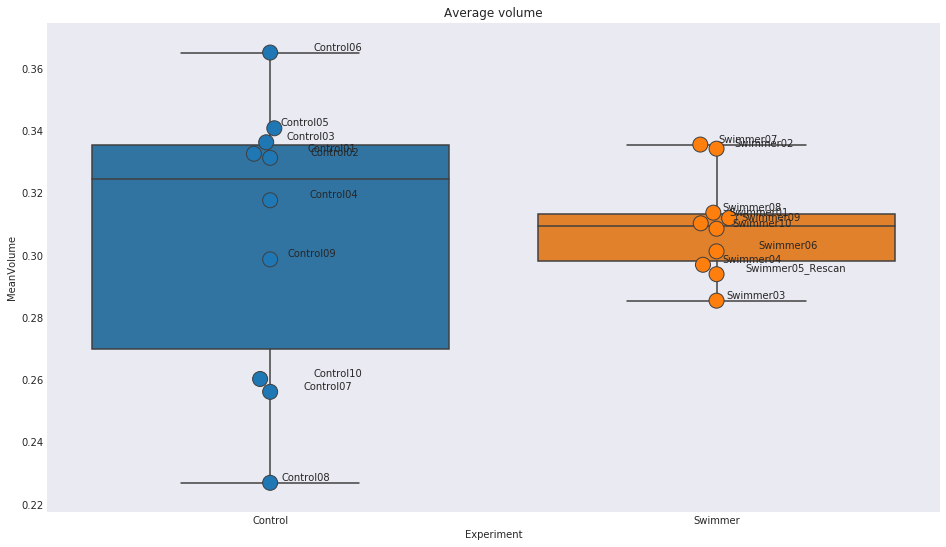

In [294]:
# Boxplot of the ratio of the gill volume to the organ volume
seaborn.boxplot(data=Data, x='Experiment', y='MeanVolume')
seaborn.swarmplot(data=Data, x='Experiment', y='MeanVolume', s=15, linewidth=1)
label=True
if label:
    shift = 0.1
    for c, row in Data.iterrows():
        if Data.Experiment[c] == 'Control':
            plt.gca().annotate(Data.Sample[c], (0 + shift * numpy.random.rand(),
                                                Data.MeanVolume[c]),
                               horizontalalignment='left', verticalalignment='bottom')         
        else:
            plt.gca().annotate(Data.Sample[c], (1 + shift * numpy.random.rand(),
                                                Data.MeanVolume[c]),
                               horizontalalignment='left', verticalalignment='bottom')
plt.title('Average volume')
plt.savefig(os.path.join(OutPutDir, 'Volumes_Average_from%04dslices.png' % NumberOfImagesToShow))
plt.show()

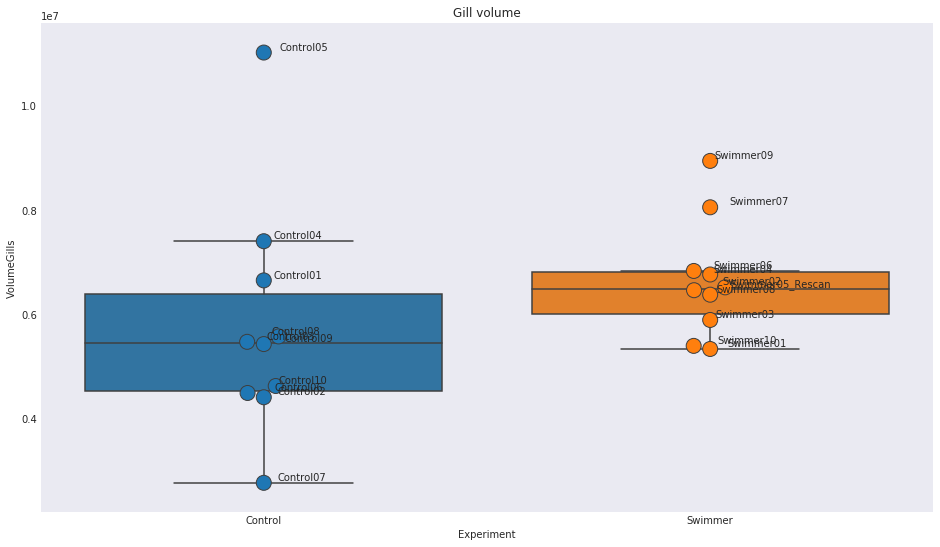

In [310]:
# Boxplot of the gills volume for each animal
seaborn.boxplot(data=Data, x='Experiment', y='VolumeGills')
seaborn.swarmplot(data=Data, x='Experiment', y='VolumeGills', s=15, linewidth=1)
label=True
if label:
    shift = 0.05
    for c, row in Data.iterrows():
        if Data.Experiment[c] == 'Control':
            plt.gca().annotate(Data.Sample[c], (0 + shift * numpy.random.rand(),
                                                Data.VolumeGills[c]),
                               horizontalalignment='left', verticalalignment='bottom')         
        else:
            plt.gca().annotate(Data.Sample[c], (1 + shift * numpy.random.rand(),
                                                Data.VolumeGills[c]),
                               horizontalalignment='left', verticalalignment='bottom')
plt.title('Gill volume')
plt.savefig(os.path.join(OutPutDir, 'Volume_Gills_from%04dslices.png' % NumberOfImagesToShow))
plt.show()

In [296]:
Data['VolumeGillsNormalized'] = [numpy.divide(gv, w) for gv, w in zip(Data.VolumeGills, Data.Length)]

In [331]:
Data[Data.Experiment=='Control'][['Sample', 'VolumeGillsNormalized']].mean()

VolumeGillsNormalized    188695.047516
dtype: float64

In [332]:
Data[Data.Experiment=='Swimmer'][['Sample', 'VolumeGillsNormalized']].mean()

VolumeGillsNormalized    212162.452652
dtype: float64

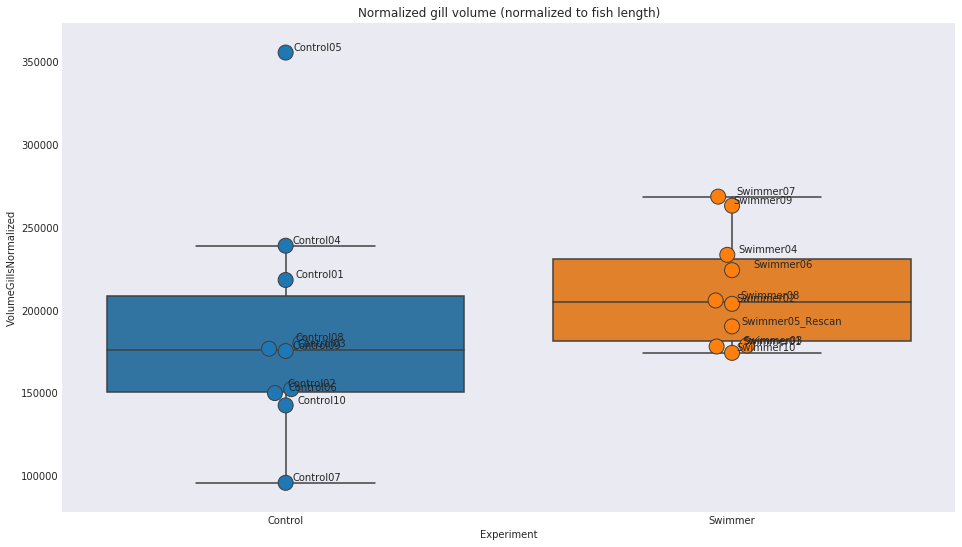

In [297]:
# Boxplot of the NORMALIZED gill volumes
seaborn.boxplot(data=Data, x='Experiment', y='VolumeGillsNormalized')
seaborn.swarmplot(data=Data, x='Experiment', y='VolumeGillsNormalized', s=15, linewidth=1)
label=True
if label:
    shift = 0.05
    for c, row in Data.iterrows():
        if Data.Experiment[c] == 'Control':
            plt.gca().annotate(Data.Sample[c], (0 + shift * numpy.random.rand(),
                                                Data.VolumeGillsNormalized[c]),
                               horizontalalignment='left', verticalalignment='bottom')         
        else:
            plt.gca().annotate(Data.Sample[c], (1 + shift * numpy.random.rand(),
                                                Data.VolumeGillsNormalized[c]),
                               horizontalalignment='left', verticalalignment='bottom')
plt.title('Normalized gill volume (normalized to fish length)')
plt.savefig(os.path.join(OutPutDir, 'Volume_Gills_Normalized_from%04dslices.png' % NumberOfImagesToShow))
plt.show()

In [298]:
# Are the means different?
t_statistic, p_value = scipy.stats.ttest_ind(Data.loc[Data.Experiment == 'Control'].VolumeGillsNormalized,
                                             Data.loc[Data.Experiment == 'Swimmer'].VolumeGillsNormalized)
print ("The difference between the 'normalized gill volume' of 'Control' and 'Swimmer' has an")
print ('F value of %0.4s and a p value of %.2g.' % (t_statistic, p_value))

The difference between the 'normalized gill volume' of 'Control' and 'Swimmer' has an
F value of -0.9 and a p value of 0.36.


In [299]:
# Drop outliers
WithoutOutliers = Data[(Data.Sample != 'Control05')]

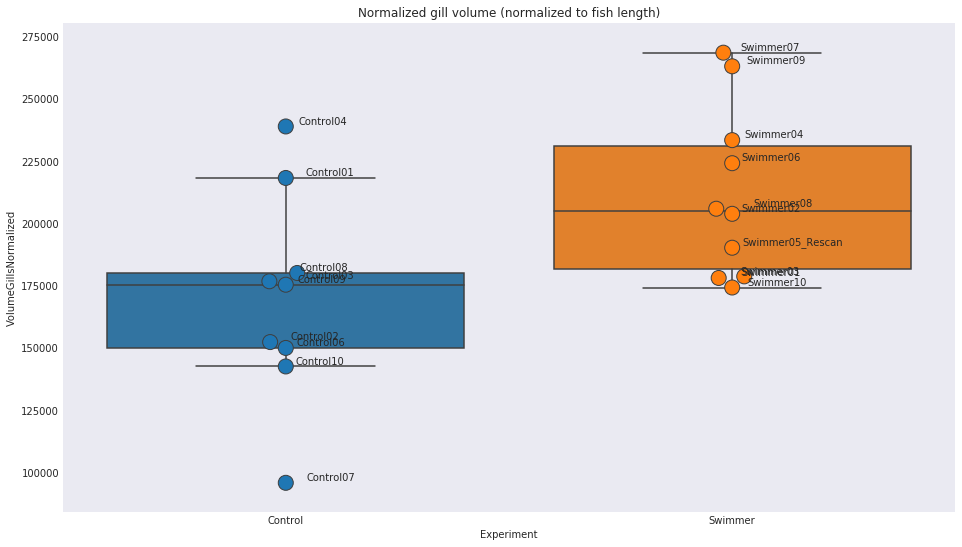

In [333]:
# Boxplot of the NORMALIZED gill volumes
seaborn.boxplot(data=WithoutOutliers, x='Experiment', y='VolumeGillsNormalized')
seaborn.swarmplot(data=WithoutOutliers, x='Experiment', y='VolumeGillsNormalized', s=15, linewidth=1)
label=True
if label:
    shift = 0.05
    for c, row in WithoutOutliers.iterrows():
        if WithoutOutliers.Experiment[c] == 'Control':
            plt.gca().annotate(WithoutOutliers.Sample[c], (0 + shift * numpy.random.rand(),
                                                WithoutOutliers.VolumeGillsNormalized[c]),
                               horizontalalignment='left', verticalalignment='bottom')         
        else:
            plt.gca().annotate(WithoutOutliers.Sample[c], (1 + shift * numpy.random.rand(),
                                                WithoutOutliers.VolumeGillsNormalized[c]),
                               horizontalalignment='left', verticalalignment='bottom')
plt.title('Normalized gill volume (normalized to fish length)')
plt.savefig(os.path.join(OutPutDir, 'Volume_Gills_Normalized_from%04dslices.png' % NumberOfImagesToShow))
plt.show()

In [340]:
# Shapiro -> Normalitätstest
scipy.stats.shapiro(WithoutOutliers.VolumeGillsNormalized)
# nicht signifikant von Normalverteilung unterschiedlich

(0.9714791178703308, 0.8056159019470215)

In [344]:
# Levene -> Varianztest
scipy.stats.levene(WithoutOutliers.loc[WithoutOutliers.Experiment == 'Control'].VolumeGillsNormalized,
                   WithoutOutliers.loc[WithoutOutliers.Experiment == 'Swimmer'].VolumeGillsNormalized)
# nicht signifikant -> Wahrscheinlich nicht nicht normalverteilt

LeveneResult(statistic=0.090613502921312747, pvalue=0.76704929546613965)

In [357]:
# Compute the Kolmogorov-Smirnov statistic on 2 samples -> Verteilungen nicht unterschiedlich?
scipy.stats.ks_2samp(WithoutOutliers.loc[WithoutOutliers.Experiment == 'Control'].VolumeGillsNormalized,
                     WithoutOutliers.loc[WithoutOutliers.Experiment == 'Swimmer'].VolumeGillsNormalized)
# knapp nicht signifikant -> wahrscheinlich nicht unterschiedliche Verteilung --> equal_var=True

Ks_2sampResult(statistic=0.56666666666666665, pvalue=0.05816855009831208)

In [360]:
# Are the means different?
# equal_var
t_statistic, p_value = scipy.stats.ttest_ind(WithoutOutliers.loc[WithoutOutliers.Experiment == 'Control'].VolumeGillsNormalized,
                                             WithoutOutliers.loc[WithoutOutliers.Experiment == 'Swimmer'].VolumeGillsNormalized,
                                             equal_var=True)  
print ("The difference between the 'normalized gill volume' of 'Control' and 'Swimmer' has an")
# Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
print ('F value of %0.4s and a p value of %.2g.' % (t_statistic, p_value / 2))

The difference between the 'normalized gill volume' of 'Control' and 'Swimmer' has an
F value of -2.3 and a p value of 0.014.


In [361]:
# Shapiro -> Normalitätstest
scipy.stats.shapiro(Data.VolumeGillsNormalized)
# nicht signifikant von Normalverteilung unterschiedlich

(0.9365776777267456, 0.20644953846931458)

In [363]:
# Levene -> Varianztest
scipy.stats.levene(Data.loc[Data.Experiment == 'Control'].VolumeGillsNormalized,
                   Data.loc[Data.Experiment == 'Swimmer'].VolumeGillsNormalized)
# nicht signifikant -> Wahrscheinlich nicht nicht normalverteilt

LeveneResult(statistic=1.006553460289378, pvalue=0.32902726924656545)

In [366]:
# Compute the Kolmogorov-Smirnov statistic on 2 samples -> Verteilungen nicht unterschiedlich?
scipy.stats.ks_2samp(Data.loc[Data.Experiment == 'Control'].VolumeGillsNormalized,
                     Data.loc[Data.Experiment == 'Swimmer'].VolumeGillsNormalized)
# knapp nicht signifikant -> wahrscheinlich nicht unterschiedliche Verteilung --> equal_var=True

Ks_2sampResult(statistic=0.5, pvalue=0.11084033741322809)

In [368]:
# Are the means different?
# equal_var
t_statistic, p_value = scipy.stats.ttest_ind(Data.loc[Data.Experiment == 'Control'].VolumeGillsNormalized,
                                             Data.loc[Data.Experiment == 'Swimmer'].VolumeGillsNormalized,
                                             equal_var=True)  
print ("The difference between the 'normalized gill volume' of 'Control' and 'Swimmer' has an")
# Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
print ('F value of %0.4s and a p value of %.2g.' % (t_statistic, p_value / 2))

The difference between the 'normalized gill volume' of 'Control' and 'Swimmer' has an
F value of -0.9 and a p value of 0.18.


In [302]:
Data['MeanVolumeNormalized'] = [numpy.divide(mv, w) for mv, w in zip(Data.MeanVolume, Data.Length)]

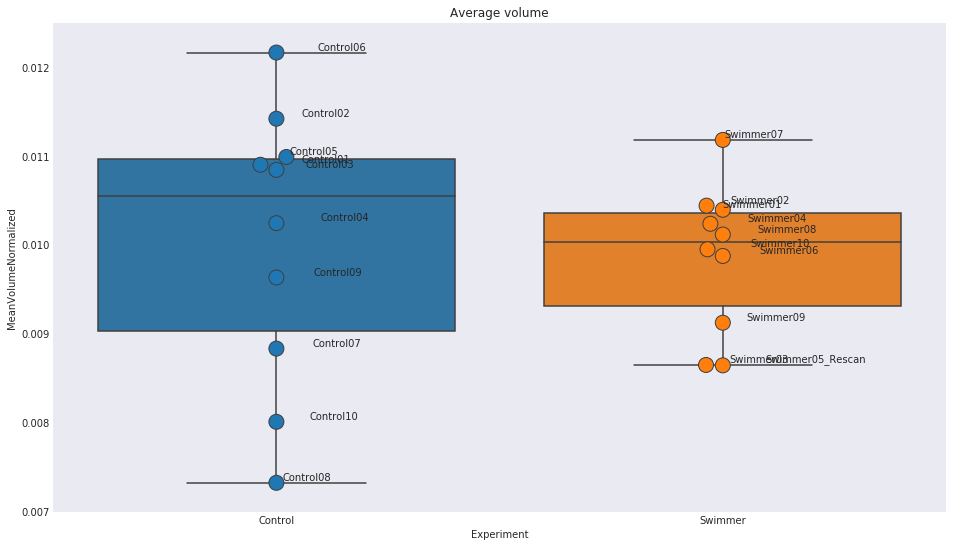

In [303]:
# Boxplot of the ratio of the NORMALIZED gill volume to the organ volume
seaborn.boxplot(data=Data, x='Experiment', y='MeanVolumeNormalized')
seaborn.swarmplot(data=Data, x='Experiment', y='MeanVolumeNormalized', s=15, linewidth=1)
label=True
if label:
    shift = 0.1
    for c, row in Data.iterrows():
        if Data.Experiment[c] == 'Control':
            plt.gca().annotate(Data.Sample[c], (0 + shift * numpy.random.rand(),
                                                Data.MeanVolumeNormalized[c]),
                               horizontalalignment='left', verticalalignment='bottom')         
        else:
            plt.gca().annotate(Data.Sample[c], (1 + shift * numpy.random.rand(),
                                                Data.MeanVolumeNormalized[c]),
                               horizontalalignment='left', verticalalignment='bottom')
plt.title('Average volume')
plt.savefig(os.path.join(OutPutDir, 'Volumes_Average_Normalized_from%04dslices.png' % NumberOfImagesToShow))
plt.show()

Here comes the statistical analysis

In [272]:
# Are the means different?
t_statistic, p_value = scipy.stats.ttest_ind(Data.loc[Data.Experiment == 'Control'].MeanArea,
                                             Data.loc[Data.Experiment == 'Swimmer'].MeanArea)
print ("The difference between the 'MeanArea' of 'Control' and 'Swimmer' has an")
print ('F value of %0.4s and a p value of %.2g.' % (t_statistic, p_value))

The difference between the 'MeanArea' of 'Control' and 'Swimmer' has an
F value of 0.12 and a p value of 0.9.


In [273]:
# We should automatically remove the outliers...
# Maybe use something from https://stackoverflow.com/questions/23199796/

In [274]:
# Drop outliers
WithoutOutliers = Data[(Data.Sample != 'Control06') &
                       (Data.Sample != 'Control07') &
                       (Data.Sample != 'Control08') &
                       (Data.Sample != 'Control10') &
                       (Data.Sample != 'Swimmer02') &                       
                       (Data.Sample != 'Swimmer07') &
                       (Data.Sample != 'Swimmer08')]

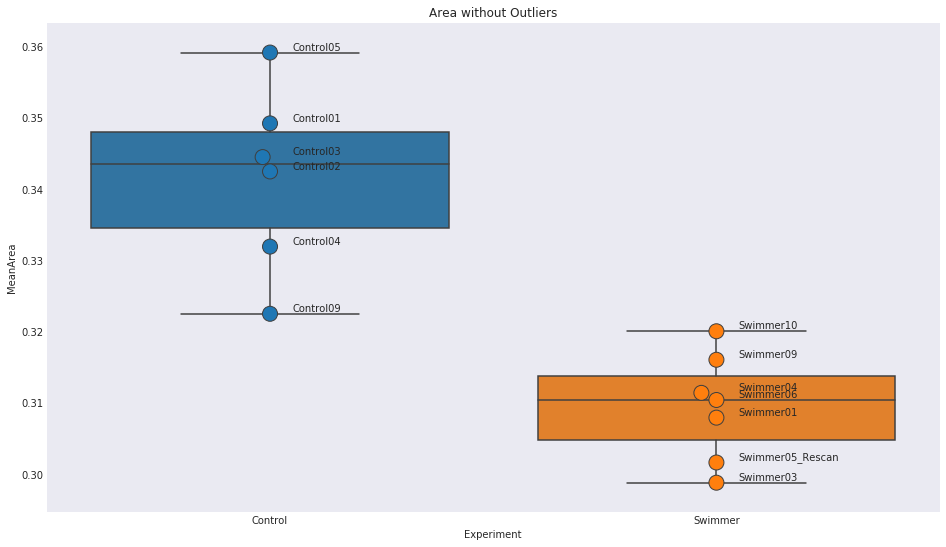

In [275]:
# Boxplot of the mean area for each animal
seaborn.boxplot(data=WithoutOutliers, x='Experiment', y='MeanArea')
seaborn.swarmplot(data=WithoutOutliers, x='Experiment', y='MeanArea', s=15, linewidth=1)
label = True
if label:
    shift = 0.05
    for c, row in WithoutOutliers.iterrows():
        if WithoutOutliers.Experiment[c] == 'Control':
            plt.gca().annotate(WithoutOutliers.Sample[c], (0+shift,WithoutOutliers.MeanArea[c]),
                               horizontalalignment='left', verticalalignment='bottom')         
        else:
            plt.gca().annotate(WithoutOutliers.Sample[c], (1+shift,WithoutOutliers.MeanArea[c]),
                               horizontalalignment='left', verticalalignment='bottom')
plt.savefig(os.path.join(OutPutDir, 'Areas_Average_from%04dslices.png' % NumberOfImagesToShow))
plt.title('Area without Outliers')
plt.show()

In [276]:
# Are the means different?
t_statistic, p_value = scipy.stats.ttest_ind(WithoutOutliers.loc[WithoutOutliers.Experiment == 'Control'].MeanArea,
                                             WithoutOutliers.loc[WithoutOutliers.Experiment == 'Swimmer'].MeanArea)
print ("WITHOUT (manually removed) OUTLIERS")
print ("The difference between the 'MeanArea' of 'Control' and 'Swimmer' has an")
print ('F value of %0.4s and a p value of %.2g.' % (t_statistic, p_value))

WITHOUT (manually removed) OUTLIERS
The difference between the 'MeanArea' of 'Control' and 'Swimmer' has an
F value of 5.60 and a p value of 0.00016.


In [277]:
# Save data at the end
Data.to_csv('Data_%s.csv' % get_git_hash())
Data.to_csv(os.path.join(OutPutDir, 'Data_%s.csv' % get_git_hash()))

In [278]:
# Save data at the end
WithoutOutliers.to_csv('Data_without_outliers_%s.csv' % get_git_hash())
WithoutOutliers.to_csv(os.path.join(OutPutDir, 'Data_without_outliers_%s.csv' % get_git_hash()))

In [279]:
print('Done!')

Done!
